In [1]:
# File to process data from Bondville sites (From November 7 2024)
# General program flow:
#   First, read in 30METDAT data file, and assign corresponding MET LABELS
#   
# Usage: ./bv13analysis.py    
# Version .25, adding in plotting
#import statsmodels.api as sm
import sys        #Needed for command line args
import csv        #For reading in text files
import subprocess #System calls
import re         #Reg expressions
import glob       #For glob command to list files
from timeit import timeit 
import pandas as pd    #Runs on pandas 1.1.5
import numpy as np
#from windrose import WindroseAxes
import io         #For running StringIO through read_csv
import matplotlib.pyplot as plt
import warnings   #For filtering warnings like All-NaN slice encountered


In [2]:
from scipy import optimize

In [3]:
#warnings.filterwarnings("error")
#metfile = sys.argv[1]                     # first command line argument is the year (2022)
#flxfile = sys.argv[2]                      # second command line arg is the day of year (101)
#fyear = iyear - 2000
fyear = 22
sb = 5.67e-8
#
#yrday = "%4d %d" % (iyear,idoy)
metfile = "BV13_180-220.30METDAT"
#
iyear = 2013
idoy = 180
yrday = "%4d %d" % (iyear,idoy)              # put into a string then


In [12]:
a2 = pd.to_datetime(yrday, format = '%Y %j') # convert to pd datetime 
start_datetime1 = a2.strftime('%Y-%m-%d 00:30:00')           # create start times for 30 minute data

df_met = pd.read_csv(metfile,delimiter= r"\s+",header=None) # read in flx data
df_metlab = pd.read_csv("./BV13_DAT.LABELS", delimiter=r"\s+",header=None) # read in the labels
met_cols = df_metlab[1].to_list()   # put the columns we want in a list and
df_met.columns = met_cols                                          # assign the column names to the input file
print (met_cols)
dt30min_index = pd.date_range(start_datetime1, periods=1968, freq="30min")         # daily pdtime index 30 min
df_met['Datetime'] = dt30min_index
df_met.set_index(df_met['Datetime'],inplace = True)                            # then make it the index
print (df_met)


['decday', 'jday', 'hour', 'wsp10', 'wdir10', 'sdir10', 'Ta', 'RH', 'pres', 'PAR-in', 'PAR-out', 'Rg-in', 'Rg-out', 'lw-in', 'lw-out', 'Rnet', 'ghf', 'precip', 'Ts', 'T2cm', 'T5cm', 'T10cm', 'T20cm', 'T50cm', 'T100cm', 'u_son', 'uw', 'u2', 'v2', 'w2', 'H', 'LE', 'Cflux', 'sm5', 'sm10', 'sm20', 'sm50', 'sm100', 'wsp5', 'wsp2', 'sdir5', 'sdir2', 'Tair10', 'Tair5', 'Tair2']
                     decday  jday  hour  wsp10  wdir10  sdir10    Ta    RH  \
Datetime                                                                     
2013-06-29 00:30:00  180.02   180    30   2.41     287     5.0  19.2  87.1   
2013-06-29 01:00:00  180.04   180   100   1.79     252    10.8  18.9  88.1   
2013-06-29 01:30:00  180.06   180   130   1.55     269     9.5  18.6  88.9   
2013-06-29 02:00:00  180.08   180   200   1.66     270     5.8  18.4  89.6   
2013-06-29 02:30:00  180.10   180   230   1.90     270     7.0  18.3  89.4   
...                     ...   ...   ...    ...     ...     ...   ...   ...   
20

In [13]:
df_met.columns

Index(['decday', 'jday', 'hour', 'wsp10', 'wdir10', 'sdir10', 'Ta', 'RH',
       'pres', 'PAR-in', 'PAR-out', 'Rg-in', 'Rg-out', 'lw-in', 'lw-out',
       'Rnet', 'ghf', 'precip', 'Ts', 'T2cm', 'T5cm', 'T10cm', 'T20cm',
       'T50cm', 'T100cm', 'u_son', 'uw', 'u2', 'v2', 'w2', 'H', 'LE', 'Cflux',
       'sm5', 'sm10', 'sm20', 'sm50', 'sm100', 'wsp5', 'wsp2', 'sdir5',
       'sdir2', 'Tair10', 'Tair5', 'Tair2', 'Datetime'],
      dtype='object')

In [14]:
df_met['sig_w'] = df_met['w2']**0.5
df_met['sig_u'] = df_met['u2']**0.5
df_met['sig_v'] = df_met['v2']**0.5
df_met['Tbulk'] = df_met['Ta']+273.18
df_met['ustar'] = (-df_met['uw'])**0.5#why the negative sign?
df_met['Ri_bulk'] = (df_met['Tair10']-df_met['Ts'])*9.8*10.0/(df_met['Tbulk']*df_met['wsp10']**2) #


In [15]:
#turbulent intensities
# compute the turbulence intensities using mean wind at 10 m
df_met['itw'] = df_met['sig_w']/df_met['wsp10']     
df_met['itu'] = df_met['sig_u']/df_met['wsp10']
df_met['itv'] = df_met['sig_v']/df_met['wsp10']
df_met['itustar'] = df_met['ustar']/df_met['wsp10']


In [16]:
# #OG code
# df_met['C1_ice'] = 1.0003+df_met['pres']/1000000.0
# df_met['C1_wat'] = 1.0007+df_met['pres']/1000000.0

# df_met['es_surf_ice'] = df_met['C1_ice']*6.1115*np.exp(22.452*df_met['Ta']/(272.55+df_met['Ta']))
# df_met['es_surf'] = df_met['C1_wat']*6.1121*np.exp(15.502*df_met['Ta']/(240.97+df_met['Ta']))
# df_met['e_air_ice'] = df_met['C1_ice']*0.01*df_met['RH']*6.1115*np.exp(22.452*df_met['Ta']/(272.55+df_met['Ta']))
# df_met['e_air'] = df_met['C1_wat']*0.01*df_met['RH']*6.1121*np.exp(15.502*df_met['Ta']/(240.97+df_met['Ta']))

# df_met.loc[df_met['Ts'] < 0, 'es_surf'] = df_met.es_surf_ice
# df_met.loc[df_met['Ta'] < 0, 'e_air'] = df_met.e_air_ice
# df_met['factor'] = 1 - 0.378*df_met['e_air']/df_met['pres']
# df_met['density'] = df_met['pres']*100*df_met['factor']/(287.04*(df_met['Ta']+273.15))  #  kg m-3
# df_met['cp'] = 1004.7*(0.522*df_met['e_air']/df_met['pres'] + 1)      #specific heat moist air J kg-1 K -1
# df_met['qs'] = df_met['es_surf']*0.622/(df_met['pres']-0.378*df_met['es_surf'])
# df_met['qa'] = df_met['e_air']*0.622/(df_met['pres']-0.378*df_met['e_air'])
# df_met['Lat'] = (2500 - 2.361*df_met['Ts'])*1000.0
# df_met.loc[df_met['Ts'] < 0, 'Lat'] = 2834000.0


In [37]:
#SP updating the surface es calculations
#include Ts while calculating es
df_met['C1_ice'] = 1.0003+4.18*df_met['pres']/1000000.0
df_met['C1_wat'] = 1.0007+3.46*df_met['pres']/1000000.0

df_met['es_surf_ice'] = df_met['C1_ice']*6.1115*np.exp(22.452*df_met['Ts']/(272.55+df_met['Ts']))
df_met['es_surf'] = df_met['C1_wat']*6.1121*np.exp(17.502*df_met['Ts']/(240.97+df_met['Ts']))

df_met['e_air_ice'] = df_met['C1_ice']*0.01*df_met['RH']*6.1115*np.exp(22.452*df_met['Ta']/(272.55+df_met['Ta']))
df_met['e_air'] = df_met['C1_wat']*0.01*df_met['RH']*6.1121*np.exp(17.502*df_met['Ta']/(240.97+df_met['Ta']))

df_met.loc[df_met['Ts'] < 0, 'es_surf'] = df_met.es_surf_ice
df_met.loc[df_met['Ta'] < 0, 'e_air'] = df_met.e_air_ice

df_met['factor'] = 1 - 0.378*df_met['e_air']/df_met['pres']
df_met['density'] = df_met['pres']*100*df_met['factor']/(287.04*(df_met['Ta']+273.15))  #  kg m-3

df_met['cp'] = 1004.7*(0.522*df_met['e_air']/df_met['pres'] + 1)      #specific heat moist air J kg-1 K -1
df_met['qs'] = df_met['es_surf']*0.622/(df_met['pres']-0.378*df_met['es_surf'])
df_met['qa'] = df_met['e_air']*0.622/(df_met['pres']-0.378*df_met['e_air'])
df_met['Lat'] = (2500 - 2.361*df_met['Ts'])*1000.0

df_met.loc[df_met['Ts'] < 0, 'Lat'] = 2834000.0


In [38]:
#H and LE calculated from bulk stats
df_met['alt_LE'] = (df_met['qs']-df_met['qa'])*df_met['density']*df_met['sig_w']*df_met['Lat']*0.03
df_met['alt_H'] = -(df_met['Tair10']-df_met['Ts'])*df_met['sig_w']*df_met['density']*df_met['cp']*.06


In [39]:
#subset
newtot = df_met.loc['2013-06-29':'2013-08-08']
fx1 = newtot[(newtot['wsp10'] > 2) & (newtot['ustar'] > 0)]


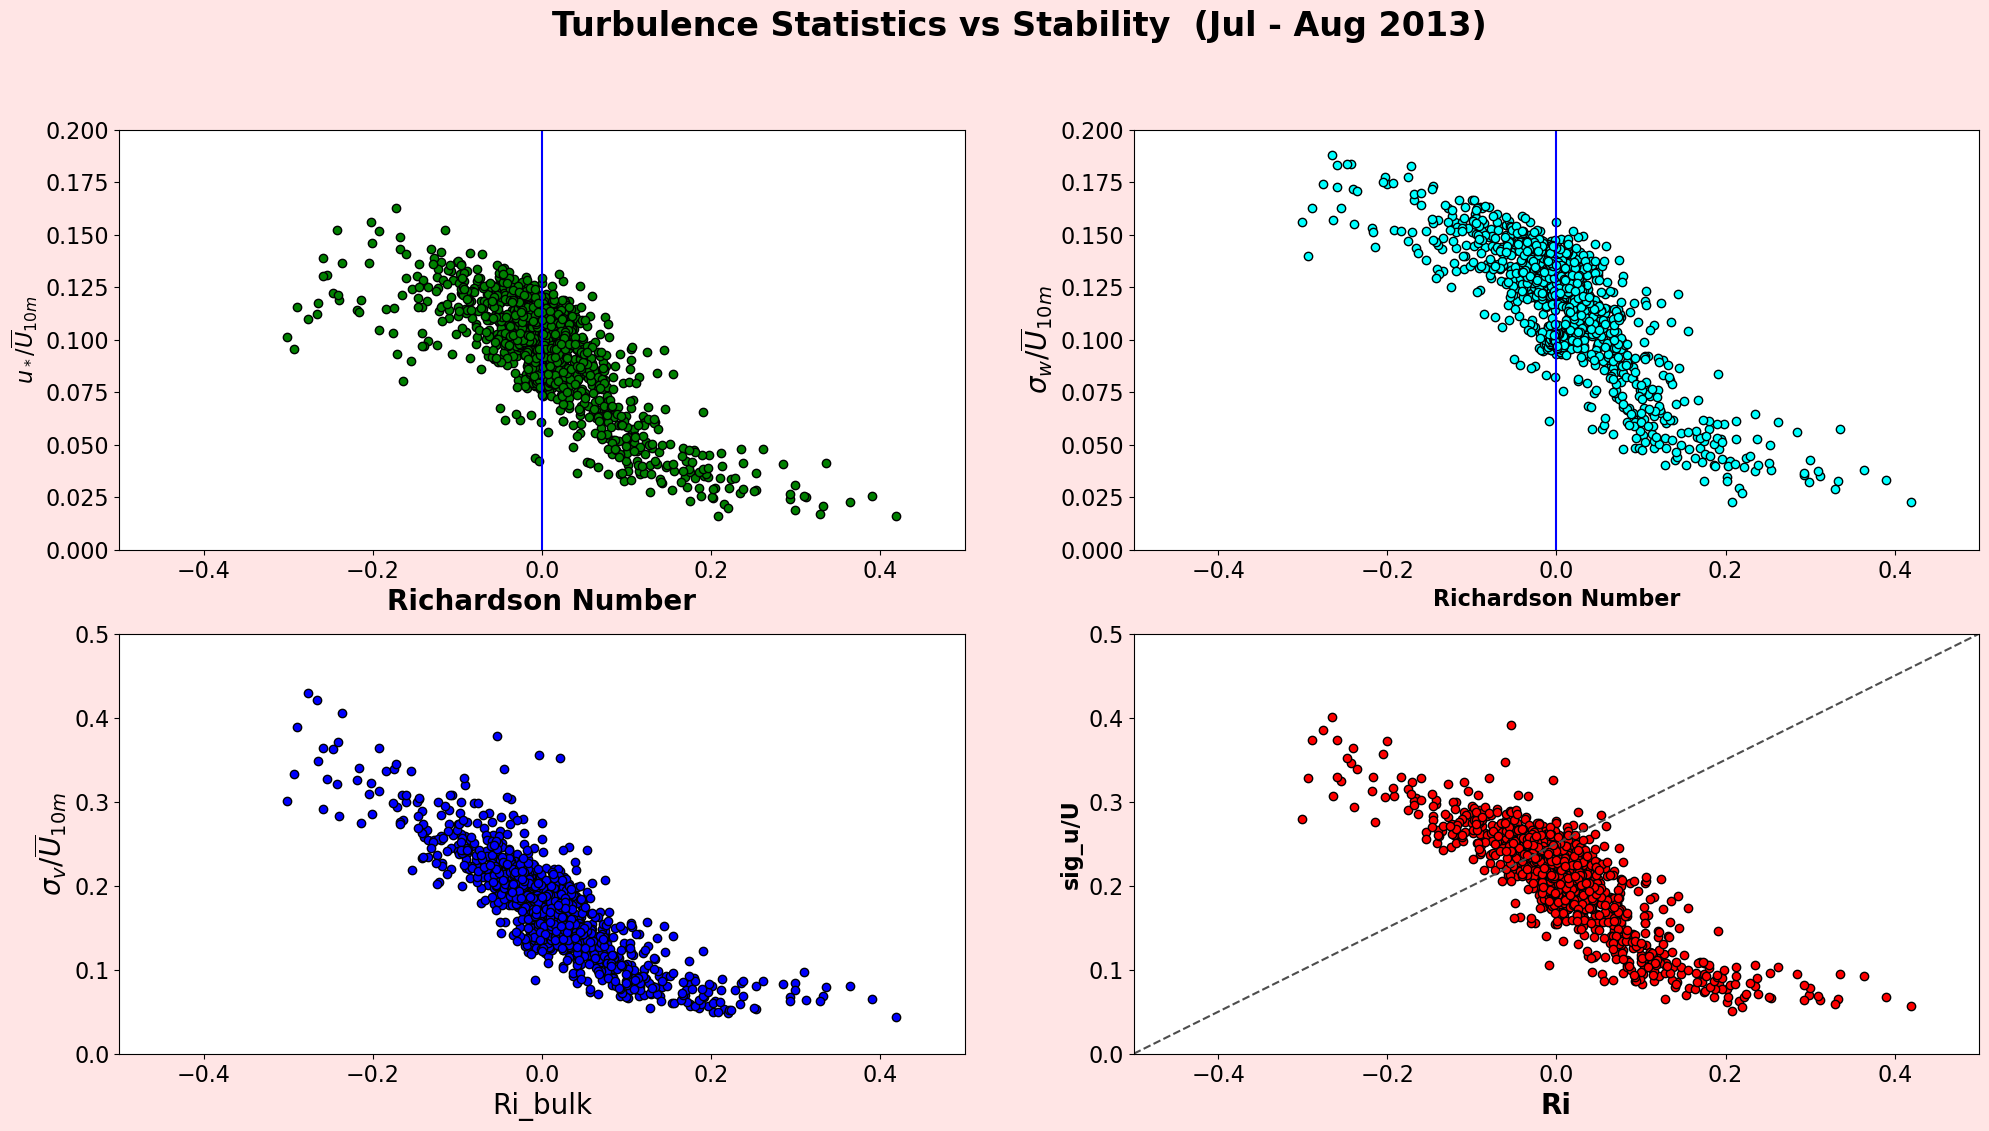

In [11]:
fig = plt.figure(facecolor=(1,0,0,0.1),figsize=(24,12))
ax = fig.add_subplot(2,2,4)
plt.axis([-0.5,0.5,0,0.5])
plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.xlabel('Ri',fontsize=20,fontweight = "bold")
plt.ylabel('sig_u/U',fontsize=16,fontweight = "bold")
plt.scatter(fx1['Ri_bulk'],fx1['itu'],color = 'red', edgecolor = 'black')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.suptitle('Turbulence Statistics vs Stability  (Jul - Aug 2013)', fontsize=24, fontweight = "bold")
#Y = fx1['alt_H']
#X = fx1['H_3m']
#model = sm.OLS(Y, X).fit()
#predictions = model.predict(X) # make the predictions by the model
#print(predictions) 
# Print out the statistics
#print(model.summary())
#
plt.subplot(222)
plt.axis([-0.5,0.5,0,0.2])
plt.ylabel(r'$\sigma_w/\overline{U}_{10m}$',fontsize=20,fontweight = "bold")
plt.xlabel('Richardson Number',fontsize=16,fontweight = "bold")
plt.axvline(x = 0,color = 'b',label = 'axvline - full height')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.scatter(fx1['Ri_bulk'],fx1['itw'],color='cyan', edgecolor = 'black')
#
plt.subplot(223)
plt.axis([-0.5,0.5,0,0.5])
plt.ylabel(r'$\sigma_v/\overline{U}_{10m}$',fontsize=20,fontweight = "bold")
plt.xlabel('Ri_bulk',fontsize=20)
#plt.axvline(x = 0,color = 'b',label = 'axvline - full height')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.scatter(fx1['Ri_bulk'],fx1['itv'],color='blue', edgecolor = 'black')
#
plt.subplot(221)
plt.axis([-0.5,0.5,0,0.2])
plt.ylabel(r'$u_*/\overline{U}_{10m}$',fontsize = 16,fontweight="bold")
plt.xlabel('Richardson Number',fontsize=20,fontweight = "bold")
plt.axvline(x = 0,color = 'b',label = 'axvline - full height')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.scatter(fx1['Ri_bulk'],fx1['itustar'],color='green', edgecolor = 'black')
#

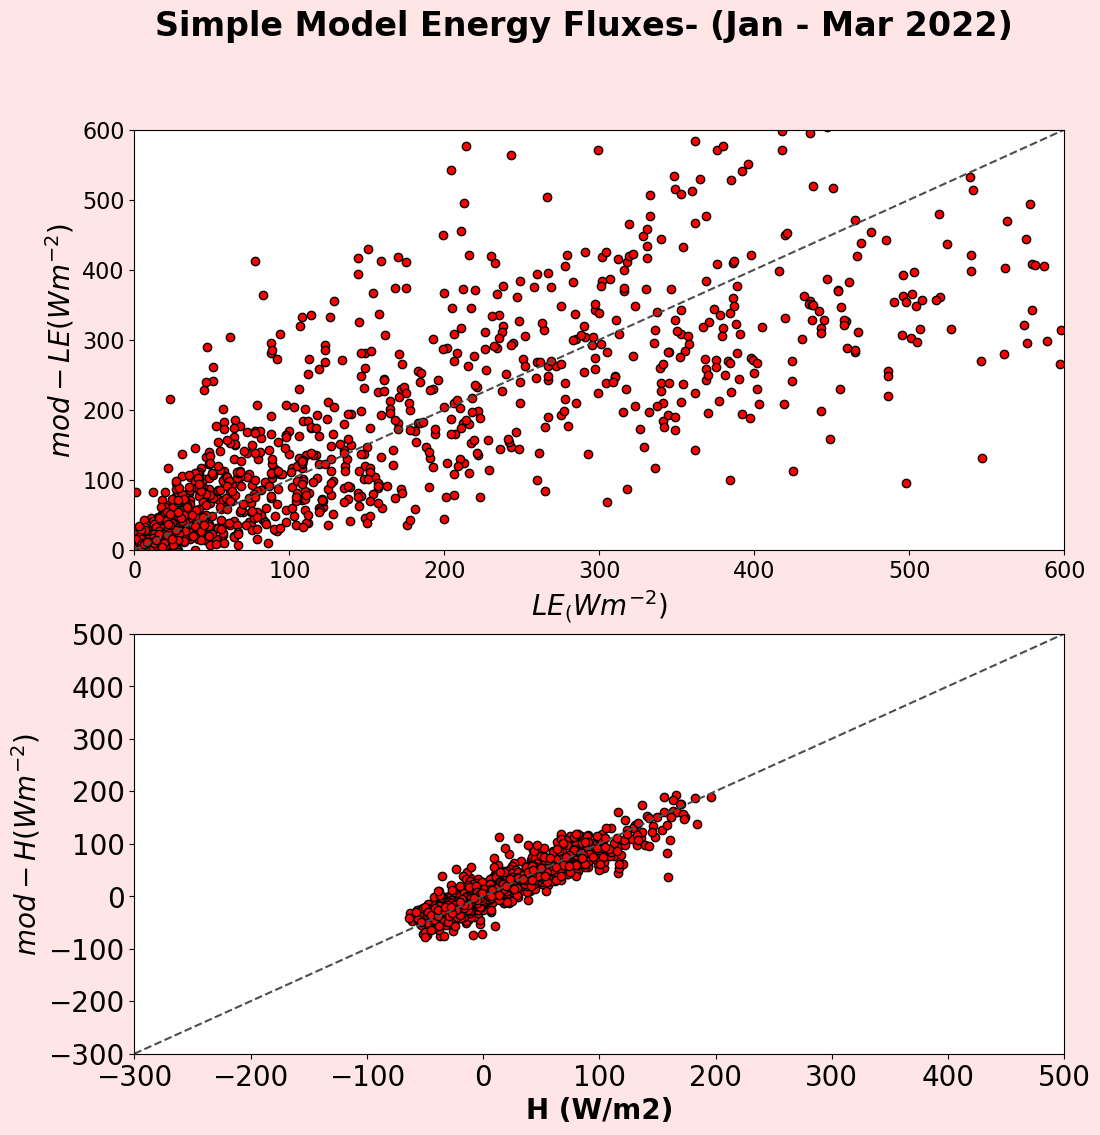

In [40]:
fig2 = plt.figure(facecolor=(1,0,0,0.1),figsize=(12,12))
plt.suptitle('Simple Model Energy Fluxes- (Jan - Mar 2022)', fontsize=24, fontweight = "bold")
ax1 = fig2.add_subplot(2,1,1)
plt.axis([0,600,0,600])
plt.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
plt.ylabel(r'$mod-LE(W m^{-2})$',fontsize=20,fontweight = "bold")
plt.xlabel(r'$LE_(W m^{-2})$',fontsize=20,fontweight = "bold")
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.scatter(fx1['LE'],fx1['alt_LE'],color = 'red', edgecolor = 'black')
#
ax2 = plt.subplot(212)
plt.axis([-300,500,-300,500])
plt.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", c=".3")
plt.ylabel(r'$mod-H (W m^{-2})$',fontsize=20,fontweight = "bold")
plt.xlabel('H (W/m2)',fontsize=20,fontweight = "bold")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.scatter(fx1['H'],fx1['alt_H'],color = 'red', edgecolor = 'black')


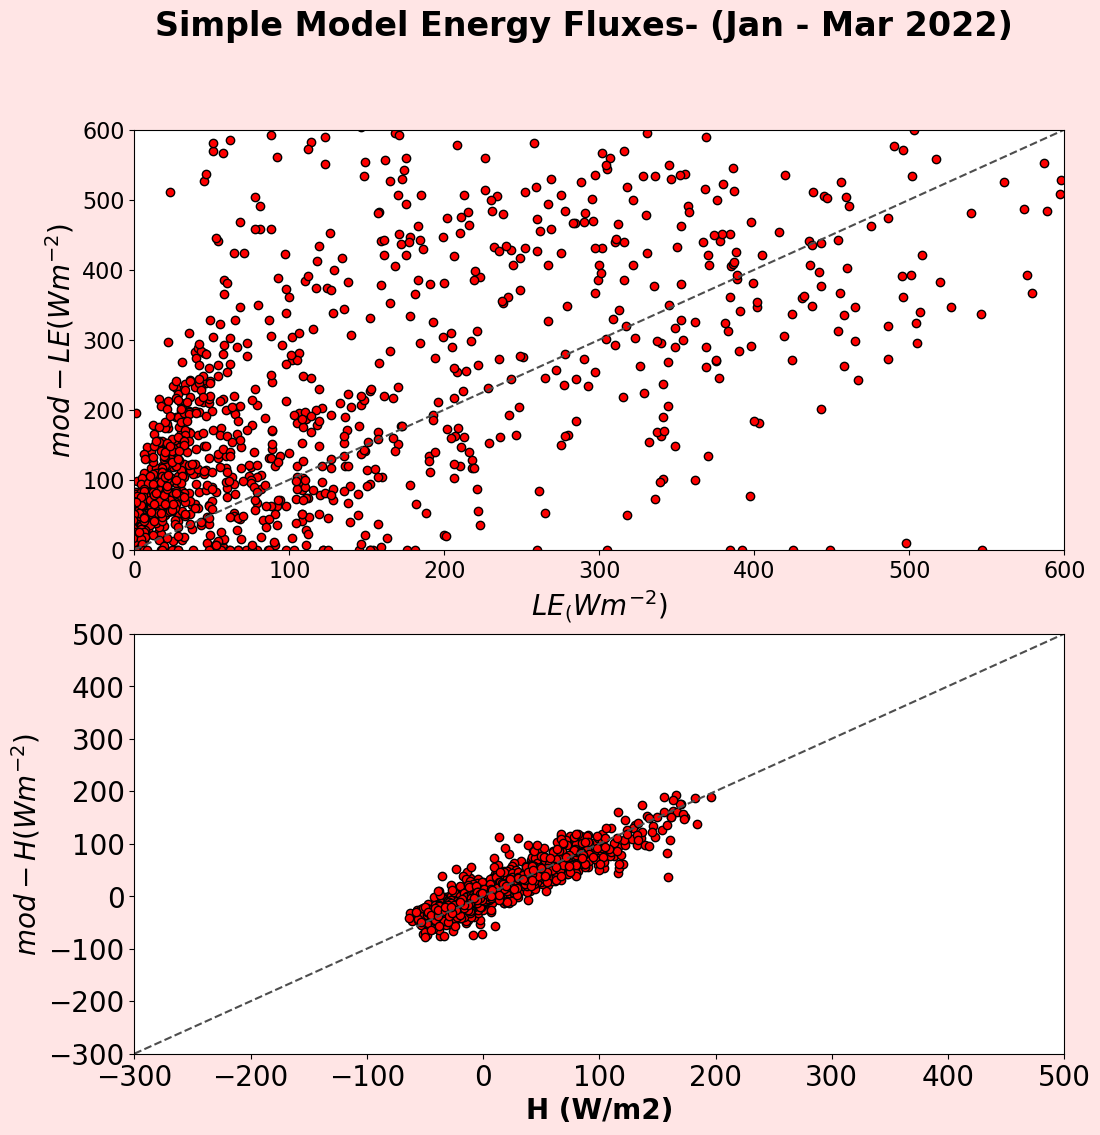

In [18]:
fig2 = plt.figure(facecolor=(1,0,0,0.1),figsize=(12,12))
plt.suptitle('Simple Model Energy Fluxes- (Jan - Mar 2022)', fontsize=24, fontweight = "bold")
ax1 = fig2.add_subplot(2,1,1)
plt.axis([0,600,0,600])
plt.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
plt.ylabel(r'$mod-LE(W m^{-2})$',fontsize=20,fontweight = "bold")
plt.xlabel(r'$LE_(W m^{-2})$',fontsize=20,fontweight = "bold")
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.scatter(fx1['LE'],fx1['alt_LE'],color = 'red', edgecolor = 'black')
#
ax2 = plt.subplot(212)
plt.axis([-300,500,-300,500])
plt.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", c=".3")
plt.ylabel(r'$mod-H (W m^{-2})$',fontsize=20,fontweight = "bold")
plt.xlabel('H (W/m2)',fontsize=20,fontweight = "bold")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.scatter(fx1['H'],fx1['alt_H'],color = 'red', edgecolor = 'black')


In [12]:
x_values_negative = np.linspace(fx1['Ri_bulk'].min(),0)

x_values_positive = np.linspace(0,fx1['Ri_bulk'].max())

unstable_y = 0.125*((1-10*x_values_negative)**(1/3))
stable_y = 0.125/((1+10*x_values_positive))


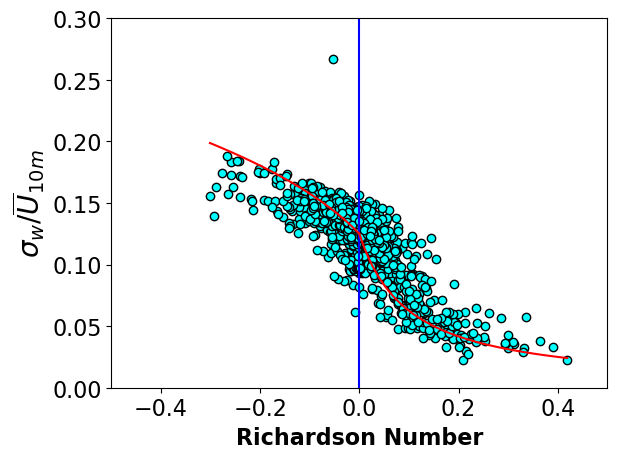

In [13]:
plt.figure()
plt.axis([-0.5,0.5,0,0.3])
plt.ylabel(r'$\sigma_w/\overline{U}_{10m}$',fontsize=20,fontweight = "bold")
plt.xlabel('Richardson Number',fontsize=16,fontweight = "bold")
plt.axvline(x = 0,color = 'b',label = 'axvline - full height')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.scatter(fx1['Ri_bulk'],fx1['itw'],color='cyan', edgecolor = 'black')

plt.plot(x_values_negative,unstable_y,'r')
plt.plot(x_values_positive,stable_y,'r')
#ax1.vlines(x=0,ymin=0,ymax=1.4,colors='r')



In [13]:
#find the functional relationship between sigma_w and Rib

def Rib_m_unstable(Rib, alpha_m, beta_m):

    return alpha_m*(1 - beta_m*Rib)**(1/3)

def Rib_m_stable(Rib, alpha_m, beta_m):

    return alpha_m/(1 + beta_m*Rib)

#filter data for non NaNs and stability
#non_nans
fx2 = fx1[fx1['itw'].notnull()]
#stability
fx2_unstable = fx2[fx2['Ri_bulk'] < 0]
fx2_stable = fx2[fx2['Ri_bulk'] > 0]

xdata = fx2_unstable['Ri_bulk'].values
ydata = fx2_unstable['itw'].values
popt_unstable, pcov_unstable = optimize.curve_fit(Rib_m_unstable, xdata, ydata, bounds=([0,3], [2, 30.]))
print('alpha_m ', popt_unstable[0],'beta_m ',popt_unstable[1])

xdata = fx2_stable['Ri_bulk'].values
ydata = fx2_stable['itw'].values
popt_stable, pcov_stable = optimize.curve_fit(Rib_m_stable, xdata, ydata, bounds=([0,3], [2, 30.]))
print('alpha_m ', popt_stable[0],'beta_m ',popt_stable[1])




alpha_m  0.12246633840204448 beta_m  7.351248458881678
alpha_m  0.12787592858502506 beta_m  5.621083556915144


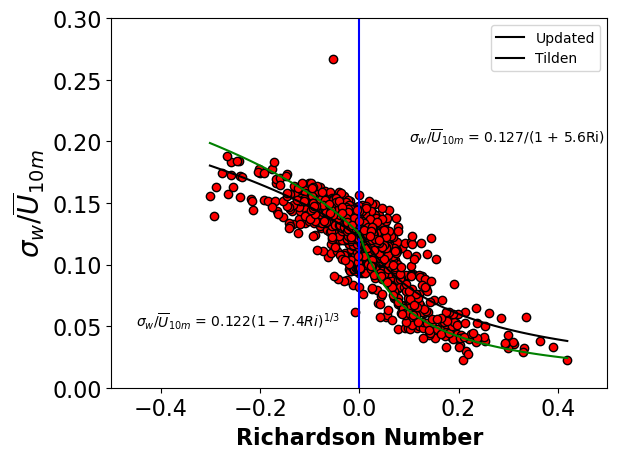

In [19]:
x_values_negative = np.linspace(fx1['Ri_bulk'].min(),0)
x_values_positive = np.linspace(0,fx1['Ri_bulk'].max())
unstable_y = 0.122*((1-7.4*x_values_negative)**(1/3))
stable_y = 0.127/((1+5.6*x_values_positive))

fig, ax = plt.subplots()
plt.axis([-0.5,0.5,0,0.3])
plt.ylabel(r'$\sigma_w/\overline{U}_{10m}$',fontsize=20,fontweight = "bold")
plt.xlabel('Richardson Number',fontsize=16,fontweight = "bold")
plt.axvline(x = 0,color = 'b',label='_nolegend_')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.scatter(fx1['Ri_bulk'],fx1['itw'],color='r', edgecolor = 'black',label='_nolegend_')
plt.text(0.1,0.2,r'$\sigma_w/\overline{U}_{10m}$ = 0.127/(1 + 5.6Ri)')
plt.text(-0.45,0.05,r'$\sigma_w/\overline{U}_{10m}$ = $0.122(1 - 7.4Ri)^{1/3}$')
plt.plot(x_values_negative,unstable_y,'k')
plt.plot(x_values_positive,stable_y,'k')
unstable_y = 0.125*((1-10*x_values_negative)**(1/3))
stable_y = 0.125/((1+10*x_values_positive))
plt.plot(x_values_negative,unstable_y,'g')
plt.plot(x_values_positive,stable_y,'g')
plt.legend(['Updated','Tilden'])

#ax1.vlines(x=0,ymin=0,ymax=1.4,colors='r')



In [140]:
#alt_H2
unstable_flag = fx1['Ri_bulk'] < 0
stable_flag = fx1['Ri_bulk'] > 0

#fx1['alt_sig_w'] = 0
alt_sigw_unstable['alt_sigw_unstable'] =  (fx1.loc[unstable_flag]['wsp10']*(0.125*( 1 - 10*fx1.loc[unstable_flag]['Ri_bulk'] )**(1/3) ))
alt_sigw_stable['alt_sigw_stable'] = (fx1.loc[stable_flag]['wsp10']*(0.125/( 1 + 10*fx1.loc[stable_flag]['Ri_bulk'] )))

#fx1['alt_H_2'] = -(fx1['Tair10']-fx1['Ts'])*fx1['alt_sig_w']*fx1['density']*fx1['cp']*.06



In [141]:
alt_sigw_unstable

Datetime
2013-06-29 06:00:00                                              0.31007
2013-06-29 06:30:00                                              0.41104
2013-06-29 07:00:00                                             0.483197
2013-06-29 07:30:00                                             0.533925
2013-06-29 08:00:00                                             0.502659
                                             ...                        
2013-08-08 15:00:00                                             0.386739
2013-08-08 15:30:00                                             0.470118
2013-08-08 16:00:00                                             0.470734
2013-08-08 16:30:00                                             0.348664
alt_sigw_unstable      Datetime
2013-06-29 06:00:00    0.310070
2013-...
Length: 695, dtype: object

In [142]:
#fx1.loc[unstable_flag]['wsp10']*(0.125*( 1 - 10*fx1.loc[unstable_flag]['Ri_bulk'] )**(1/3) )
pd.merge(alt_sigw_unstable,alt_sigw_stable)

ValueError: Cannot merge a Series without a name